In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import random
import math
from scipy.optimize import newton
import pandas as pd
from gurobipy import *
import mosek
import cvxpy as cp
import scipy.integrate as integrate# RT：mis
import scipy.stats as st

In [2]:
def gamma_pdf(d, shape, scale):
        return (1 / (scale ** shape)) * (d ** (shape - 1)) * np.exp(-d / scale)

class news_exp_norm(object):
    # Meaning that the true demand distribution is exponential and the localization function is normal
    # Should do a more generic code later to pick and choose the demand distribution and localization function
     # shape  = 1 expoential; shape = 0.9 and 1.1 try; scale =  theta 
    
    def __init__(self, No, Nm, Nn, Nc, p, c, mu, sigma, shape, rlow_w, rhigh_w, rlow_k, rhigh_k, rnum): # RT： mis 0902: add one shape
        self.No = No # Number of samples in a data set
        self.Nm = Nm # Number of samples for the localization function
        self.Nn = Nn # Number of data sets to average over
        self.Nc = Nc
        self.p = p 
        self.c = c
        self.shape = shape
        
        self.rlow_w = rlow_w 
        self.rhigh_w = rhigh_w 
        self.rlow_k = rlow_k 
        self.rhigh_k = rhigh_k 
        self.rnum = rnum
        
        if (mu - 6*sigma < 0):
            print('Warning: mean of normal is not more than 6 sigmas away from 0! Negative values possible!')
            return
        else:
            self.mu = mu # Mean of the normal distribution
            self.sigma = sigma # Sd of the normal distribution
        
        # generates dataset 
        #distr = 0 : normal; distr = 1: uniform; distr = 2: gamma 
        
            np.random.seed(734)
            self.et = np.random.normal(loc=self.mu, scale = self.sigma, size = self.Nm)
            self.ett = np.random.normal(loc=self.mu, scale = self.sigma, size = self.Nm)
            self.ettt = np.random.normal(loc=self.mu, scale = self.sigma, size = self.Nc)

        
    # 拖出去
    def solvefunc(self, q, ht):
        return sum( (self.c - self.p * math.exp(-1 * q / self.et[i])) * \
                    (math.exp(1 - ht / self.et[i]) / self.et[i] * \
                    self.mu)**self.No for i in range(self.Nm) ) 
        #return sum( (self.c - self.p * math.exp(-1 * q / self.et[i])) * \
        #            math.exp(-1 * self.No * ht / self.et[i]) / (self.et[i])**self.No * \
        #            math.exp(self.No) * (self.mu ** self.No) for i in range(self.Nm) ) 
    # 加速
    def int_bisect(self, lw, upp, ht, tol = 10**(-10)):
        # abort
        if (self.solvefunc(q = lw, ht = ht) * self.solvefunc(q = upp, ht = ht) > 0):
            print('Aborting as lower and upper bounds same sign!')
            return 0
    
        uppnow = upp
        lwnow = lw
        uppval = self.solvefunc(q = uppnow, ht = ht)
        lwval = self.solvefunc(q = lwnow, ht = ht)
    
        while (uppnow - lwnow > tol):
            trythis = (uppnow + lwnow)/2
            thisval = self.solvefunc(q = trythis, ht = ht)
            if uppval < 0:
                if thisval < 0:
                    uppnow = trythis
                    uppval = thisval
                else: 
                    lwnow = trythis
                    lwval = thisval
            else:
                if thisval < 0: 
                    lwnow = trythis
                    lwval = thisval
                else:
                    uppnow = trythis
                    uppval = thisval
        
        return uppnow
    
    def pto(self, ht):
        return ht * np.log(self.p / self.c)
        
    def ops(self, ht):
        return ht * ((self.p/self.c)**(1/(self.No+1))-1)*self.No
    
    def oquad(self,ht):
        return self.ops(ht)- ht**2/(self.No**3)
    
    # saa model
    def saa(self,dat_samp):
        m = Model('saa')
        m.setParam('OutputFlag', 0)
        ### order quantity
        ds_q = m.addVar(lb = 0, name="ds_q") 
        ### variables used to derive the linear optimization problem 
        ds_t = m.addVars(self.No, lb = -GRB.INFINITY, name="ds_t") 

        ### objective function
        obj = quicksum([ (self.c*ds_q - self.p*ds_t[i]) for i in range(self.No) ])/self.No
        m.setObjective(obj, GRB.MINIMIZE)

        ### constraints
        m.addConstrs((ds_t[i] - ds_q <= 0 for i in range(self.No)))
        m.addConstrs((ds_t[i] - dat_samp[i] <= 0 for i in range(self.No) ))

        # solve the model
        m.optimize()
        return ds_q.X
    
    # ro model with box uncertainty set
    def ro(self, th_lw, th_upp):
        return th_lw * np.log(self.p / self.c)
    
    # dro model with moment uncertainty set
    def dro_moment(self, d_hat, sig_hat_sq):
        m = Model('dro_moment')
        m.setParam('OutputFlag', 0)
        #m.Params.FeasibilityTol = 10**(-9)
        #m.Params.OptimalityTol = 10**(-9)
        #m.Params.BarQCPConvTol = 0
        #m.Params.FuncPieces = -2
        #m.Params.FuncPieceError = 10**(-5)
        #m.Params.ConstrVio = 10**(-9)
        ### order quantity
        ds_q = m.addVar(lb = 0, name="ds_q") 
        ### variables in the robust counterpart
        ds_lam = m.addVar(lb = -GRB.INFINITY, name="ds_lam")
        ds_bet = m.addVar(lb = 0, name="ds_bet")
        ds_gam = m.addVar(lb = -GRB.INFINITY, name="ds_gam")
        ## dual variables to reformulate robust counterpart
        # first constraint
        ds_x1 = m.addVar(lb = 0, name="ds_x1")
        ds_y1 = m.addVar(lb = -GRB.INFINITY, name="ds_y1")
        ds_z1 = m.addVar(lb = -GRB.INFINITY, name="ds_z1")
        # second constraints
        ds_x2 = m.addVar(lb = 0, name="ds_x2")
        ds_y2 = m.addVar(lb = -GRB.INFINITY, name="ds_y2")
        ds_z2 = m.addVar(lb = -GRB.INFINITY, name="ds_z2")
        
        ### objective function
        obj = d_hat * ds_lam + sig_hat_sq * ds_bet + ds_gam 
        m.setObjective(obj, GRB.MINIMIZE)
        ### constraints 
        # first constraint
        m.addConstr( -0.5*ds_x1 + 0.5*ds_y1 + d_hat*ds_z1 + ds_gam - self.c*ds_q >= 0 )
        m.addConstr( 0.5*ds_x1 + 0.5*ds_y1 - ds_bet <= 0 )
        m.addConstr( ds_z1 - ds_lam - self.p <= 0 )
        m.addConstr( ds_y1*ds_y1 + ds_z1*ds_z1 <= ds_x1*ds_x1)
        # second constraint 
        m.addConstr( -0.5*ds_x2 + 0.5*ds_y2 + d_hat*ds_z2 + ds_gam - self.c*ds_q + self.p*ds_q >= 0 )
        m.addConstr( 0.5*ds_x2 + 0.5*ds_y2 - ds_bet <= 0 )
        m.addConstr( ds_z2 - ds_lam  <= 0 )
        m.addConstr( ds_y2*ds_y2 + ds_z2*ds_z2 <= ds_x2*ds_x2)
        
        # solve the model
        m.optimize()
        
        return ds_q.X
    
    # dro model with wasserstein uncertainty set
    def dro_wasserstein(self, dat_samp, r):
        m = Model('dro_wasserstein')
        m.setParam('OutputFlag',0)
        #m.Params.FeasibilityTol = 10**(-9)
        #m.Params.OptimalityTol = 10**(-9)
        
        ### order quantity 
        ds_q =  m.addVar(lb = 0, name="ds_q") 
        ### variables in the robust counterpart
        ds_bet = m.addVars(self.No, lb = -GRB.INFINITY, name='ds_bet')
        ds_lam = m.addVar(lb = 0, name='ds_lam')
        ### variables in the reformulation
        # first constraint
        ds_x = m.addVars(self.No, lb = 0, name="ds_x")
        ds_y = m.addVars(self.No, lb = 0, name="ds_y")


        ### objective function
        obj = r*ds_lam + quicksum([ds_bet[i] for i in range(self.No)])/self.No 
        m.setObjective(obj, GRB.MINIMIZE)

        ### constraints
        # first constraint
        m.addConstrs((dat_samp[i]*(ds_y[i] - ds_x[i]) + ds_bet[i] - self.c*ds_q >= 0 for i in range(self.No)))
        m.addConstrs((ds_x[i] + ds_y[i] - ds_lam <= 0 for i in range(self.No)))
        m.addConstrs((ds_y[i] - ds_x[i] - self.p <= 0 for i in range(self.No)))
        # second constraint
        m.addConstrs((ds_bet[i] - self.c*ds_q + self.p*ds_q >= 0 for i in range(self.No)))

        # solve the model
        m.optimize()
        
        return ds_q.X
    
    # dro model with Kullback-Leibler uncertainy set
    def dro_kl(self, dat_samp, r):
        ### order quantity
        ds_q = cp.Variable(nonneg = True)

        ### variables in the robust counterpart
        ds_lam = cp.Variable(nonneg = True)
        ds_gam = cp.Variable()
        ds_bet = cp.Variable(self.No, nonneg = True)

        ### variables in the exponential cone 
        av_exp = cp.Variable(self.No)
        obj = r*ds_lam + ds_gam + sum(ds_bet)/self.No

        # objective funciton
        objective = cp.Minimize(obj)

        ## constraints
        constraints = []

        for i in range(self.No):
            constraints += [ cp.constraints.ExpCone( -av_exp[i],ds_lam,ds_bet[i] ) ]
            constraints += [ av_exp[i] + self.c*ds_q  - self.p*ds_q  - ds_lam - ds_gam  <= 0 ]
            constraints += [ av_exp[i] + self.c*ds_q - self.p*dat_samp[i] - ds_lam - ds_gam <= 0]

        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver = cp.MOSEK)

        return ds_q.value
       
    #def true_profit(self, q, theta):
     #   return self.p * theta * (1 - np.exp(-1 * q / theta)) - self.c * q
    #RT:mis
    def true_profit(self, q, theta):
        expected_value,_= integrate.quad(lambda d: (self.p*np.min([d,q]) - self.c*q) * gamma_pdf(d, self.shape, theta), 0, np.inf)
        return  expected_value
    
    # cross validation on radius
    # change the bechmark to the inverse of gamma
    def cv_dro(self):
        cv_wasserstein = {}
        cv_kl = {}
        cv_opt = {}
        cv_wasserstein_reg = {}
        cv_kl_reg = {}

        rset_w = np.linspace(self.rlow_w, self.rhigh_w, num = self.rnum)
        rset_k = np.linspace(self.rlow_k, self.rhigh_k, num = self.rnum)

        for j in range(self.Nc):
            dat_cv = np.random.gamma(self.shape, scale= self.ettt[j], size=self.No) #np.random.exponential(scale = self.ettt[j], size = self.No)
            hth_cv = np.mean(dat_cv)

            #qovp_cv = self.int_bisect(lw = 1, upp = 40, ht = hth_cv) 
            #cv_ovp[j] = self.true_profit(q = qovp_cv, theta = self.ettt[j]) 
            q_opt = st.gamma.ppf((1-self.c/self.p), a = self.shape, scale = self.ettt[j])
            cv_opt[j] = self.true_profit(q = q_opt, theta = self.ettt[j]) 

            for r_ind in range(self.rnum):
                qdrow_cv = self.dro_wasserstein(dat_samp = dat_cv, r = rset_w[r_ind])
                cv_wasserstein[(j,r_ind)] = self.true_profit(q = qdrow_cv, theta = self.ettt[j])

                qdrok_cv = self.dro_kl(dat_samp = dat_cv, r = rset_k[r_ind])
                cv_kl[(j,r_ind)] = self.true_profit(q = qdrok_cv, theta = self.ettt[j])

        for r_ind in range(self.rnum):
            cv_wasserstein_reg[r_ind] = np.mean([ max(cv_opt[j] - cv_wasserstein[j,r_ind],0) for j in range(self.Nc)])
            cv_kl_reg[r_ind] = np.mean([ max(cv_opt[j] - cv_kl[j,r_ind],0) for j in range(self.Nc)])
   
        # find the r with the minimal regret
        list_w = [cv_wasserstein_reg[r_ind] for r_ind in range(self.rnum)]
        list_k = [cv_kl_reg[r_ind] for r_ind in range(self.rnum)]
        r_ind_w = list_w.index(min(list_w))
        r_ind_k = list_k.index(min(list_k))
        
        return [rset_w[r_ind_w], rset_k[r_ind_k], rset_w, cv_wasserstein_reg, rset_k, cv_kl_reg ]
    
    
    def simulator(self):
        
        # creates empty dictionary to store results
        self.p_ovp = {} # p for profit
        self.p_pto = {}
        self.p_opstat = {}
        self.p_oquad = {}
        self.p_saa = {}
        self.p_ro = {}
        self.p_drom = {}
        self.p_drow = {}
        self.p_drok = {}
        self.p_exp = {} # the best profit
        
        self.q_ovp = {}
        self.q_pto = {}
        self.q_opstat = {}
        self.q_oquad = {}
        self.q_saa = {}
        self.q_ro = {}
        self.q_drom = {}
        self.q_drow = {}
        self.q_drok = {}
        self.q_exp = {} # with true theta
        
        self.difp_ovp = {}
        self.difp_pto = {}
        self.difp_opstat = {}
        self.difp_oquad = {}
        self.difp_saa = {}
        self.difp_ro = {}
        self.difp_drom = {}
        self.difp_drow = {}
        self.difp_drok = {}
        
        self.dif_ovp = {}
        self.dif_pto = {}
        self.dif_opstat = {}
        self.dif_oquad = {}
        self.dif_saa = {}
        self.dif_ro = {}
        self.dif_drom = {}
        self.dif_drow = {}
        self.dif_drok = {}
        #self.q_exp = {} # with true theta
        
        self.cv = {}
        
        self.cv[0] = self.cv_dro()
        
        for eth in self.ett:
            for i in range(self.Nn):
                #dat = np.random.exponential(scale = eth, size = self.No) # generates data
                #RT:mis
                dat = np.random.gamma(self.shape, scale= eth, size=self.No) # 
                hth = np.mean(dat) # computes theta hat
                vth = np.sqrt(np.sum([(dat[ind] - hth )**2 for ind in range(self.No) ])/(self.No-1) )
                #np.var(dat)
                sdth = np.sqrt(np.sum([(dat[ind] - hth )**2 for ind in range(self.No) ])/((self.No-1)*(self.No-2)) )
                # np.std(dat)/np.sqrt(self.No)
                
                qpto = self.pto(hth) # computes q_pto
                self.q_pto[(eth, hth)] = qpto
                self.p_pto[(eth, hth)] = self.true_profit(q = qpto, theta = eth) # computes true profit of q_pto
                
                qops = self.ops(hth)
                self.q_opstat[(eth, hth)] = qops
                self.p_opstat[(eth, hth)] = self.true_profit(q = qops, theta = eth)
                
                qoquad = self.oquad(hth)
                self.q_oquad[(eth, hth)] = qoquad
                self.p_oquad[(eth, hth)] = self.true_profit(q = qoquad, theta = eth)
                
                qovp = self.int_bisect(lw = 1, upp = 40, ht = hth) # Initial search near q_pto
                # RT: Here you may need to change to upp >20  since the mean is 20
                self.q_ovp[(eth,hth)] = qovp
                self.p_ovp[(eth, hth)] = self.true_profit(q = qovp, theta = eth)
                
                qsaa = self.saa(dat)
                self.q_saa[(eth,hth)] = qsaa
                self.p_saa[(eth, hth)] =  self.true_profit(q = qsaa, theta = eth)
                
                qro = self.ro(th_lw = 0.95*hth, th_upp =1.05*hth)
                self.q_ro[(eth,hth)] = qro
                self.p_ro[(eth, hth)] =  self.true_profit(q = qro, theta = eth)
                
                qdrom = self.dro_moment(d_hat = hth, sig_hat_sq = vth)
                self.q_drom[(eth,hth)] = qdrom
                self.p_drom[(eth, hth)] =  self.true_profit(q = qdrom, theta = eth)
                
                qdrow = self.dro_wasserstein(dat_samp = dat, r = self.cv[0][0])
                self.q_drow[(eth,hth)] = qdrow
                self.p_drow[(eth, hth)] =  self.true_profit(q = qdrow, theta = eth)
                
                qdrok = self.dro_kl(dat_samp = dat, r = self.cv[0][1])
                self.q_drok[(eth,hth)] = qdrok
                self.p_drok[(eth, hth)] =  self.true_profit(q = qdrok, theta = eth)
                
                qexp = st.gamma.ppf((1-self.c/self.p), a = self.shape, scale = eth) # computes ex-post qpto
                self.q_exp[(eth,hth)] = qexp
                self.p_exp[(eth, hth)] = self.true_profit(q = qexp, theta = eth)
                
                self.dif_pto[(eth, hth)] = self.p_exp[(eth, hth)] - self.p_pto[(eth, hth)]
                self.difp_pto[(eth, hth)] = (self.p_exp[(eth, hth)] - self.p_pto[(eth, hth)])/self.p_exp[(eth, hth)]
                self.dif_ovp[(eth, hth)] = self.p_exp[(eth, hth)] - self.p_ovp[(eth, hth)]
                self.difp_ovp[(eth, hth)] = (self.p_exp[(eth, hth)] - self.p_ovp[(eth, hth)])/self.p_exp[(eth, hth)]
                self.dif_opstat[(eth, hth)] = self.p_exp[(eth, hth)] - self.p_opstat[(eth, hth)]
                self.difp_opstat[(eth, hth)] = (self.p_exp[(eth, hth)] - self.p_opstat[(eth, hth)])/self.p_exp[(eth, hth)]
                
                self.dif_saa[(eth, hth)] = self.p_exp[(eth, hth)] - self.p_saa[(eth, hth)]
                self.difp_saa[(eth, hth)] = (self.p_exp[(eth, hth)] - self.p_saa[(eth, hth)])/self.p_exp[(eth, hth)]
                
                self.dif_ro[(eth, hth)] = self.p_exp[(eth, hth)] - self.p_ro[(eth, hth)]
                self.difp_ro[(eth, hth)] = (self.p_exp[(eth, hth)] - self.p_ro[(eth, hth)])/self.p_exp[(eth, hth)]
                
                self.dif_drom[(eth, hth)] = self.p_exp[(eth, hth)] - self.p_drom[(eth, hth)]
                self.difp_drom[(eth, hth)] = (self.p_exp[(eth, hth)] - self.p_drom[(eth, hth)])/self.p_exp[(eth, hth)]
                
                self.dif_drow[(eth, hth)] = self.p_exp[(eth, hth)] - self.p_drow[(eth, hth)]
                self.difp_drow[(eth, hth)] = (self.p_exp[(eth, hth)] - self.p_drow[(eth, hth)])/self.p_exp[(eth, hth)]
                
                self.dif_drok[(eth, hth)] = self.p_exp[(eth, hth)] - self.p_drok[(eth, hth)]
                self.difp_drok[(eth, hth)] = (self.p_exp[(eth, hth)] - self.p_drok[(eth, hth)])/self.p_exp[(eth, hth)]

In [3]:
#NEN = news_exp_norm(No = 5, Nm = 50, Nn = 200, p = 2, c = 1, low = 18, high = 22)
NEN = news_exp_norm(No = 5, Nm = 50, Nn = 200, Nc = 20, p = 2, c = 1, mu = 20, sigma = 1,shape = 0.85,
                   rlow_w = 0.0001, rhigh_w = 5, rlow_k = 0.04, rhigh_k = 5, rnum = 1000) # make sure there is no negative value 

In [4]:
NEN.simulator() 

Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-11


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


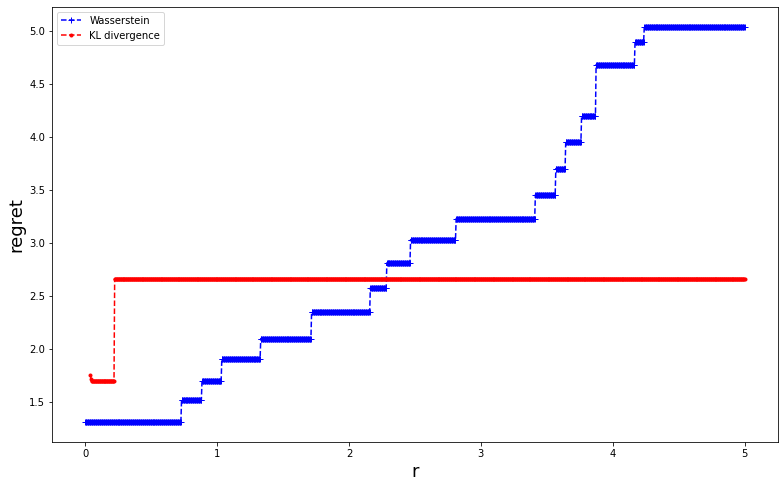

In [5]:
# cross validation
plt.figure(figsize=(13,8))
plt.plot(NEN.cv[0][2], np.array([NEN.cv[0][3][r_ind] for r_ind in range(1000)]), 'b+--') 
plt.plot(NEN.cv[0][4], np.array([NEN.cv[0][5][r_ind] for r_ind in range(1000)]), 'r.--') 
plt.xlabel('r',fontsize = 18)
plt.ylabel('regret',fontsize = 18)
plt.legend(labels = ['Wasserstein','KL divergence'],fontsize = 10)
plt.savefig('cv_r_mis_85.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


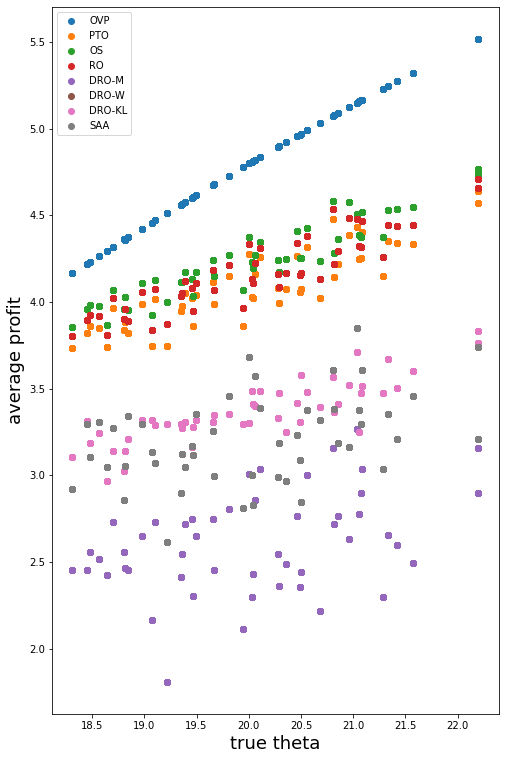

In [6]:
#news_exp_norm(No = 5, Nm = 50, Nn = 50, p = 2, c = 1, mu = 10, sigma = 1)
#when Nn =100 now change to Nn=1000
eths = [ eth for eth, hth in NEN.p_ovp.keys() ]
avgs_ovp = [ np.mean([ NEN.p_ovp[eth, hth] for eth, hth in NEN.p_ovp.keys() if eth == ethe]) for ethe in eths ]
#avgs_exp = [ np.mean([ NEN.p_ovp[eth, hth] for eth, hth in NEN.p_exp.keys() if eth == ethe]) for ethe in eths ]
avgs_pto = [ np.mean([ NEN.p_pto[eth, hth] for eth, hth in NEN.p_pto.keys() if eth == ethe]) for ethe in eths ]
avgs_ops = [ np.mean([ NEN.p_opstat[eth, hth] for eth, hth in NEN.p_opstat.keys() if eth == ethe]) for ethe in eths ]
avgs_saa = [ np.mean([ NEN.p_saa[eth, hth] for eth, hth in NEN.p_saa.keys() if eth == ethe]) for ethe in eths ]
avgs_ro = [ np.mean([ NEN.p_ro[eth, hth] for eth, hth in NEN.p_ro.keys() if eth == ethe]) for ethe in eths ]
avgs_drom = [ np.mean([ NEN.p_drom[eth, hth] for eth, hth in NEN.p_drom.keys() if eth == ethe]) for ethe in eths ]
avgs_drow = [ np.mean([ NEN.p_drow[eth, hth] for eth, hth in NEN.p_drow.keys() if eth == ethe]) for ethe in eths ]
avgs_drok = [ np.mean([ NEN.p_drok[eth, hth] for eth, hth in NEN.p_drok.keys() if eth == ethe]) for ethe in eths ]

#avgs_oquad = [ np.mean([ NEN.p_oquad[eth, hth] for eth, hth in NEN.p_oquad.keys() if eth == ethe]) for ethe in eths ]

plt.figure(figsize=(8,13))
plt.plot(eths, avgs_ovp, 'o') # blue is ovp
plt.plot(eths, avgs_pto, 'o') # yellow is pto
plt.plot(eths, avgs_ops, 'o') # yellow is pto
# plt.plot(eths, avgs_saa, 'o') 
plt.plot(eths, avgs_ro, 'o') 
plt.plot(eths, avgs_drom, 'o') 
plt.plot(eths, avgs_drow, 'o') 
plt.plot(eths, avgs_drok, 'o') 
plt.plot(eths, avgs_saa, 'o') 

#plt.plot(eths, avgs_oquad, 'yo') # yellow is pt
#plt.plot(eths, avgs_exp, 'yo') # yellow is pt

plt.xlabel('true theta',fontsize = 18)
plt.ylabel('average profit',fontsize = 18)
plt.legend(labels = ['OVP', 'PTO','OS','RO','DRO-M','DRO-W','DRO-KL','SAA'],fontsize = 10)
plt.savefig('profit_mis_85.eps')

In [16]:
#news_exp_norm(No = 5, Nm = 50, Nn = 50, p = 2, c = 1, mu = 10, sigma = 1)
#for same theta with differnt sample
difavgs_ovp = [ np.mean([ NEN.difp_ovp[eth, hth] for eth, hth in NEN.p_ovp.keys() if eth == ethe]) for ethe in eths ]
#difavgs_exp = [ np.mean([ NEN.p_ovp[eth, hth] for eth, hth in NEN.p_exp.keys() if eth == ethe]) for ethe in eths ]
difavgs_pto = [ np.mean([ NEN.difp_pto[eth, hth] for eth, hth in NEN.p_pto.keys() if eth == ethe]) for ethe in eths ]
difavgs_ops = [ np.mean([ NEN.difp_opstat[eth, hth] for eth, hth in NEN.p_opstat.keys() if eth == ethe]) for ethe in eths ]
#avgs_oquad = [ np.mean([ NEN.p_oquad[eth, hth] for eth, hth in NEN.p_oquad.keys() if eth == ethe]) for ethe in eths ]

difavgs_saa = [ np.mean([ NEN.difp_saa[eth, hth] for eth, hth in NEN.p_saa.keys() if eth == ethe]) for ethe in eths ]
difavgs_ro = [ np.mean([ NEN.difp_ro[eth, hth] for eth, hth in NEN.p_ro.keys() if eth == ethe]) for ethe in eths ]
difavgs_drom = [ np.mean([ NEN.difp_drom[eth, hth] for eth, hth in NEN.p_drom.keys() if eth == ethe]) for ethe in eths ]
difavgs_drow = [ np.mean([ NEN.difp_drow[eth, hth] for eth, hth in NEN.p_drow.keys() if eth == ethe]) for ethe in eths ]
difavgs_drok = [ np.mean([ NEN.difp_drok[eth, hth] for eth, hth in NEN.p_drok.keys() if eth == ethe]) for ethe in eths ]


plt.figure(figsize=(8,13))
plt.plot(eths, difavgs_ovp, 'o') # blue is ovp
plt.plot(eths, difavgs_pto, 'o') # yellow is pto
plt.plot(eths, difavgs_ops, 'o') # yellow is pto
#plt.plot(eths, avgs_oquad, 'yo') # yellow is pt
#plt.plot(eths, avgs_exp, 'yo') # yellow is pt
plt.plot(eths, difavgs_ro, 'o') 
plt.plot(eths, difavgs_drom, 'o') 
plt.plot(eths, difavgs_drow, 'o') 
plt.plot(eths, difavgs_drok, 'o') 
plt.plot(eths, difavgs_saa, 'o') 

plt.xlabel('true theta',fontsize = 18)
plt.ylabel('regret percentile',fontsize = 18)
plt.legend(labels =['OVP', 'PTO','OS','RO','DRO-M','DRO-W','DRO-KL','SAA'],fontsize = 10)
plt.savefig('regret_mis_85.eps')

KeyboardInterrupt: 

In [8]:
np.average(np.array(difavgs_ovp))

0.05065047137653023

In [9]:
np.average(np.array(difavgs_ops))

0.15908509838327214

In [10]:
np.average(np.array(difavgs_pto))

0.1884434438178767

In [11]:
# on average，perform better within the range

In [13]:
import pickle

In [14]:
example_dict = {'cv':NEN.cv,'eths':eths, 'avgs_ovp':avgs_ovp, 'avgs_pto':avgs_pto, 'avgs_ops':avgs_ops,'avgs_ro':avgs_ro,
                'avgs_drom':avgs_drom, 'avgs_drow':avgs_drow, 'avgs_drok':avgs_drok, 'avgs_saa':avgs_saa,
               'difavgs_ovp':difavgs_ovp, 'difavgs_pto':difavgs_pto, 'difavgs_ops':difavgs_ops, 'difavgs_ro':difavgs_ro,
               'difavgs_drom':difavgs_drom, 'difavgs_drow':difavgs_drow, 'difavgs_drok': difavgs_drok,
               'difavgs_saa':difavgs_saa}
pickle_out = open("20230904_mis_85.pickle","wb")
pickle.dump(example_dict, pickle_out)
pickle_out.close()

In [ ]:
plt.figure(figsize=(8,13))
plt.plot(eths, avgs_ovp, 'o') # blue is ovp
plt.plot(eths, avgs_pto, 'o') # yellow is pto
plt.plot(eths, avgs_ops, 'o') # yellow is pto
# plt.plot(eths, avgs_saa, 'o') 
plt.plot(eths, avgs_ro, 'o') 
plt.plot(eths, avgs_drom, 'o') 
plt.plot(eths, avgs_drow, 'o') 
plt.plot(eths, avgs_drok, 'o') 
plt.plot(eths, avgs_saa, 'o') 

#plt.plot(eths, avgs_oquad, 'yo') # yellow is pt
#plt.plot(eths, avgs_exp, 'yo') # yellow is pt

plt.xlabel('true theta',fontsize = 18)
plt.ylabel('average profit',fontsize = 18)
plt.legend(labels = ['OVP', 'PTO','OS','RO','DRO-M','DRO-W','DRO-KL','SAA'],fontsize = 10)
plt.savefig('profit_mis_85.eps')